In [91]:
# Multimodal Vibe Classifier: ResNet50 + Metadata + Dual Image Inputs

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models


In [92]:
# Check CUDA avilability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [93]:
# === CONFIG ===
CSV_PATH = "datasets/vibe_features_selected.csv"
SENTINEL_COL = "sentinel_jpg_path"
OSM_COL = "osm_image_path"
LABEL_COL = "vibe_class"
BATCH_SIZE = 1
IMG_SIZE = 224
RANDOM_STATE = 42

In [ ]:
def load_and_preprocess_csv(csv_path):
    """
    Loads a CSV file and prepares it for multimodal training by encoding labels,
    converting categorical columns into usable format, and organizing feature lists.

    Args:
        csv_path (str): Path to the input CSV containing image paths, labels, and metadata features.

    Returns:
        df (pd.DataFrame): The processed DataFrame with encoded labels and cleaned features.
        numeric_cols (list): List of numeric metadata features (e.g., distances, densities).
        one_hot_cols (list): List of binary one-hot encoded categorical features (e.g., traffic level).
        all_tabular_cols (list): Combined list of all tabular (non-image) feature column names.
    """
    df = pd.read_csv(csv_path)
    df[LABEL_COL] = LabelEncoder().fit_transform(df[LABEL_COL])

    # One-hot encode categorical columns
    # df = pd.get_dummies(df, columns=["traffic_level", "time_of_day"])
    # df = pd.get_dummies(df, columns=["traffic_level_medium", "traffic_level_low"])
    
    # Feature Engineered 
    df["traffic_level_low"] = df["traffic_level_low"].astype(int)
    df["traffic_level_medium"] = df["traffic_level_medium"].astype(int)

    # All features
    # numeric_cols = ["dist_to_park", "road_density", "road_length", "populartimes_peak_avg"]
    # one_hot_cols = [c for c in df.columns if "traffic_level_" in c or "time_of_day_" in c]

    # Feature Engineered
    numeric_cols = ["dist_to_park", "road_density", "road_length"]
    one_hot_cols = [c for c in df.columns if "traffic_level_" in c ]
    all_tabular_cols = numeric_cols + one_hot_cols

    return df, numeric_cols, one_hot_cols, all_tabular_cols


In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

def split_and_scale(df, all_tabular_cols, test_size=0.1, val_size=0.2, random_state=42):
    """
    Splits the DataFrame into train, val, test sets and returns a scaler-transformer function.
    
    Parameters:
        df (pd.DataFrame): Full dataset
        all_tabular_cols (list): List of tabular feature column names
        test_size (float): Proportion of data for test set
        val_size (float): Proportion of data for val set (from remaining after test split)
        random_state (int): Seed for reproducibility

    Returns:
        df_train, df_val, df_test (pd.DataFrame): Split data
        scale_fn (callable): Function to apply scaling on tabular data
    """
    # Step 1: Split off test set
    df_temp, df_test = train_test_split(
        df, test_size=test_size, stratify=df[LABEL_COL], random_state=random_state
    )

    # Step 2: Split remaining into train and val
    adjusted_val_size = val_size / (1 - test_size)
    df_train, df_val = train_test_split(
        df_temp, test_size=adjusted_val_size, stratify=df_temp[LABEL_COL], random_state=random_state
    )

    # Step 3: Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(df_train[all_tabular_cols])
    joblib.dump(scaler, "scaler.pkl")

    # Step 4: Return scale function that applies the same scaling
    def scale_fn(df_part):
        return scaler.transform(df_part[all_tabular_cols])

    return df_train, df_val, df_test, scale_fn


In [ ]:
# Dataset Class
class VibeDataset(Dataset):
    """A custom PyTorch Dataset class for handling multimodal data (images and tabular data).
    
    Args:
        df (pd.DataFrame): DataFrame containing file paths and labels
        scale_fn (callable): Function to scale/normalize the tabular data
        transform (callable, optional): Optional transform to be applied to the images
    
    Attributes:
        df (pd.DataFrame): Processed DataFrame with reset index
        transform (callable): Image transformations
        tabular_data (np.ndarray): Scaled tabular features
    """
    def __init__(self, df, scale_fn, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tabular_data = scale_fn(df)

    def __len__(self):
        """Returns the number of samples in the dataset.
        
        Returns:
            int: Length of the dataset
        """
        return len(self.df)

    def __getitem__(self, idx):
        """Gets a single sample from the dataset at the given index.
        
        Args:
            idx (int): Index of the sample to retrieve
            
        Returns:
            tuple: Contains:
                - sentinel_img (torch.Tensor): Transformed Sentinel-2 image
                - osm_img (torch.Tensor): Transformed OSM image  
                - tabular (torch.Tensor): Scaled tabular features
                - label (torch.Tensor): Ground truth label
        """
        row = self.df.iloc[idx]
        sentinel_img = Image.open(row[SENTINEL_COL]).convert("RGB")
        osm_img = Image.open(row[OSM_COL]).convert("RGB")

        if self.transform:
            sentinel_img = self.transform(sentinel_img)
            osm_img = self.transform(osm_img)

        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        label = torch.tensor(row[LABEL_COL], dtype=torch.long)
        return sentinel_img, osm_img, tabular, label


In [ ]:
def create_dataloaders(df_train, df_val, df_test, scale_fn):
    """Creates PyTorch DataLoaders for train, validation and test sets.
    
    Args:
        df_train (pd.DataFrame): Training set DataFrame
        df_val (pd.DataFrame): Validation set DataFrame
        df_test (pd.DataFrame): Test set DataFrame
        scale_fn (callable): Function to scale/normalize tabular data
        
    Returns:
        tuple: Contains:
            - train_loader (DataLoader): DataLoader for training set
            - val_loader (DataLoader): DataLoader for validation set
            - test_loader (DataLoader): DataLoader for test set
            - train_ds (VibeDataset): Training dataset object
    """
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_ds = VibeDataset(df_train, scale_fn, transform=transform)
    val_ds = VibeDataset(df_val, scale_fn, transform=transform)
    test_ds = VibeDataset(df_test, scale_fn, transform=transform)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE )

    return train_loader, val_loader, test_loader, train_ds


In [ ]:
class DualResNetWithMetadata(nn.Module):
    """A multimodal neural network combining two ResNet50 models (for images) with an MLP (for tabular data).
    
    Args:
        tabular_dim (int): Dimensionality of the tabular features
        num_classes (int): Number of output classes
        
    Attributes:
        resnet_sentinel (nn.Module): ResNet50 for Sentinel-2 images
        resnet_osm (nn.Module): ResNet50 for OSM images
        mlp (nn.Sequential): MLP for processing tabular data
        classifier (nn.Sequential): Final classification layers
    """
    def __init__(self, tabular_dim, num_classes):
        super().__init__()
        self.resnet_sentinel = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet_osm = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet_sentinel.fc = nn.Identity()
        self.resnet_osm.fc = nn.Identity()

        self.mlp = nn.Sequential(
            nn.Linear(tabular_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(2048 * 2 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, img_sentinel, img_osm, tabular):
        """Forward pass of the network.
        
        Args:
            img_sentinel (torch.Tensor): Batch of Sentinel-2 images
            img_osm (torch.Tensor): Batch of OSM images
            tabular (torch.Tensor): Batch of tabular features
            
        Returns:
            torch.Tensor: Model predictions/logits
        """
        feat_sen = self.resnet_sentinel(img_sentinel)
        feat_osm = self.resnet_osm(img_osm)
        feat_tab = self.mlp(tabular)
        combined = torch.cat([feat_sen, feat_osm, feat_tab], dim=1)
        return self.classifier(combined)


In [99]:
# Initializing Loss, Optimizer and model
from torch import nn
from torch.optim import Adam,SGD
from torchvision import models
from torch.optim.lr_scheduler import StepLR  

def initialize_model(tabular_dim, num_classes):
    """
    Initializes the dual-head model with classification and regression outputs.

    Returns:
        model (nn.Module): Initialized dual-head CNN model.
        criterion_cls (nn.Module): Loss function for classification.
        criterion_reg (nn.Module): Loss function for regression.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
    """
    model = DualResNetWithMetadata(tabular_dim,num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), betas=(0.9, 0.99))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    return model, criterion,  optimizer, scheduler


# Training

In [5]:
from tqdm import tqdm
def train_one_epoch(model,train_loader,criterion,optimizer):
    """
    Trains the model for one epoch using both classification and regression objectives.

    Args:
        model (nn.Module): The dual-head model with classification and regression outputs.
        train_loader (DataLoader): DataLoader for the training dataset.
        criterion (loss): Loss function for the classification head (CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.

    Returns:
        float: Total accumulated training loss over the epoch.
    """
    model.train()
    train_loss = 0.0
    for sentinel_img, osm_img, tabular, label in tqdm(train_loader):
        sentinel_img = sentinel_img.to(device)
        osm_img = osm_img.to(device)
        tabular = tabular.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(sentinel_img, osm_img, tabular)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss

In [6]:
def eval_one_epoch(model, val_loader, criterion):
    """
    Evaluates the model on the validation set for one epoch and computes total loss.

    Args:
        model (nn.Module): The dual-head model to be evaluated.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (loss): Classification loss function (CrossEntropyLoss).

    Returns:
        float: Total validation loss for the epoch.
    """
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sentinel_img, osm_img, tabular, label in tqdm(val_loader):
            sentinel_img = sentinel_img.to(device)
            osm_img = osm_img.to(device)
            tabular = tabular.to(device)
            label = label.to(device)
            output = model(sentinel_img, osm_img, tabular)
            loss = criterion(output, label)
            val_loss += loss.item()

    return val_loss

In [7]:
import matplotlib.pyplot as plt

def train(num_epochs, model, criterion,  optimizer, scheduler, train_loader, val_loader):
    """
    Trains the model using dual loss objectives over a specified number of epochs.

    Args:
        num_epochs (int): Number of training epochs.
        model (nn.Module): Model to be trained.
        criterion (loss): Classification loss (CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        scheduler (lr_scheduler): Learning rate scheduler.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        best_model_path (string): Path where the best model is saved
        train_loss_list (list of float): Training losses per epoch.
        val_loss_list (list of float): Validation losses per epoch.
    """
  
    best_val_loss = float('inf')
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model,train_loader,criterion,optimizer)
        avg_train_loss = train_loss/len(train_loader)
        train_loss_list.append(avg_train_loss)
        val_loss = eval_one_epoch(model, val_loader, criterion)
        avg_val_loss = val_loss/len(val_loader)
        val_loss_list.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = rf'checkpoints\best_model_{epoch}_fe_fixed.pt'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, os.path.join(os.getcwd(), best_model_path))  # Save checkpoint to file
            print(f"Best model saved at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

    return best_model_path, train_loss_list, val_loss_list


In [8]:
# PLot the learning Curves
def plt_lc(num_epochs,train_loss_list, val_loss_list):
    """
    Plots the training and validation loss curves over epochs.

    Args:
        num_epochs (int): Total number of epochs.
        train_loss_list (list of float): Training loss values.
        val_loss_list (list of float): Validation loss values.

    Returns:
        None
    """
    X = [x+1 for x in range(num_epochs)]
    plt.plot(X,train_loss_list, c='r', label= "Training Curve")
    plt.plot(X,val_loss_list, c='b', label = "Validation Curve")
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.xticks([x for x in range(0,num_epochs,5)])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Testing

In [ ]:
# Generate Predictions
def predict(best_model_path, model, test_loader, num_classes):
    """
    Loads the best checkpoint and evaluates the model on test data.
    Also computes and prints classification & regression metrics.

    Args:
        best_model_path (str): Path to the saved model checkpoint.
        model (nn.Module): The model architecture to load weights into.

    Returns:
        torch.tensor: Confusion Matrix Result
    """
    import torch
    from torchmetrics.classification import MulticlassConfusionMatrix
    from torchmetrics.classification import Precision, Recall, F1Score
    from torchmetrics.classification import Accuracy
    from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError, R2Score


    # Load the model checkpoint
    checkpoint = torch.load(os.path.join(os.getcwd(), best_model_path))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)  


    # Initialize metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
    f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)

    # Initialize storage for labels and predictions
    all_labels = []
    all_preds = []
 
    # Evaluation
    model.eval()
    with torch.no_grad():
        for sentinel_img, osm_img, tabular, label in tqdm(test_loader):
            sentinel_img = sentinel_img.to(device)
            osm_img = osm_img.to(device)
            tabular = tabular.to(device)
            label = label.to(device)
            output = model(sentinel_img, osm_img, tabular)
        
            _, preds = torch.max(output, 1)

            # Store predictions and true labels
            all_labels.append(label)
            all_preds.append(preds)

            # Update metrics
            confusion_matrix.update(preds, label)
            precision.update(preds, label)
            recall.update(preds, label)
            f1_score.update(preds, label)
            accuracy.update(preds, label)
           

    # Compute final metrics
    confusion_matrix_result = confusion_matrix.compute()
    precision_result = precision.compute()
    recall_result = recall.compute()
    f1_score_result = f1_score.compute()
    accuracy_result = accuracy.compute()

    print("Confusion Matrix:")
    print(confusion_matrix_result)
    print(f"Precision: {precision_result:.4f}")
    print(f"Recall: {recall_result:.4f}")
    print(f"F1 Score: {f1_score_result:.4f}")
    print(f"Accuracy: {accuracy_result:.4f}")
    
    return confusion_matrix_result



In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import MulticlassConfusionMatrix

def plot_confusion_matrix(confusion_matrix_result):
    """
    Plots the confusion matrix as a heatmap using seaborn.

    Args:
        confusion_matrix_result (Tensor): Torch tensor of shape (C, C) representing confusion matrix.

    Returns:
        None
    """
    # Convert to numpy
    confmat_np = confusion_matrix_result.cpu().numpy()
    classes = ['Fun','IL','NV','WGW'] 
    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(confmat_np, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=[f"Pred {i}" for i in classes],
                yticklabels=[f"True {i}" for i in classes])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix Heatmap")
    plt.tight_layout()
    plt.show()
    plt.savefig(rf"D:\vibe_place_mapper\results\cm.png")

Number of features:5


100%|██████████| 38/38 [00:00<00:00, 38.73it/s]


Epoch [1/15] | Train Loss: 1.3994 | Val Loss: 3.6180
Best model saved at epoch 1 with Val Loss: 3.6180


100%|██████████| 38/38 [00:00<00:00, 41.53it/s]


Epoch [2/15] | Train Loss: 1.1557 | Val Loss: 14.1084


100%|██████████| 38/38 [00:00<00:00, 46.00it/s]


Epoch [3/15] | Train Loss: 0.9253 | Val Loss: 3.2993
Best model saved at epoch 3 with Val Loss: 3.2993


100%|██████████| 38/38 [00:00<00:00, 40.18it/s]


Epoch [4/15] | Train Loss: 0.8367 | Val Loss: 1.8980
Best model saved at epoch 4 with Val Loss: 1.8980


100%|██████████| 38/38 [00:00<00:00, 44.56it/s]


Epoch [5/15] | Train Loss: 0.7754 | Val Loss: 24.7505


100%|██████████| 38/38 [00:00<00:00, 45.52it/s]


Epoch [6/15] | Train Loss: 0.8106 | Val Loss: 6.1647


100%|██████████| 38/38 [00:00<00:00, 41.41it/s]


Epoch [7/15] | Train Loss: 0.8061 | Val Loss: 17.5639


100%|██████████| 38/38 [00:00<00:00, 43.80it/s]


Epoch [8/15] | Train Loss: 0.7312 | Val Loss: 50.0953


100%|██████████| 38/38 [00:00<00:00, 43.15it/s]


Epoch [9/15] | Train Loss: 0.7248 | Val Loss: 15.1478


100%|██████████| 38/38 [00:00<00:00, 42.42it/s]


Epoch [10/15] | Train Loss: 0.6976 | Val Loss: 21.6992


100%|██████████| 38/38 [00:00<00:00, 43.07it/s]


Epoch [11/15] | Train Loss: 0.6759 | Val Loss: 31.7687


100%|██████████| 38/38 [00:00<00:00, 45.03it/s]


Epoch [12/15] | Train Loss: 0.6887 | Val Loss: 27.6431


100%|██████████| 38/38 [00:00<00:00, 40.70it/s]


Epoch [13/15] | Train Loss: 0.6288 | Val Loss: 10.5013


100%|██████████| 38/38 [00:00<00:00, 43.04it/s]


Epoch [14/15] | Train Loss: 0.5467 | Val Loss: 10.8704


100%|██████████| 38/38 [00:00<00:00, 44.75it/s]

Epoch [15/15] | Train Loss: 0.5058 | Val Loss: 24.2426


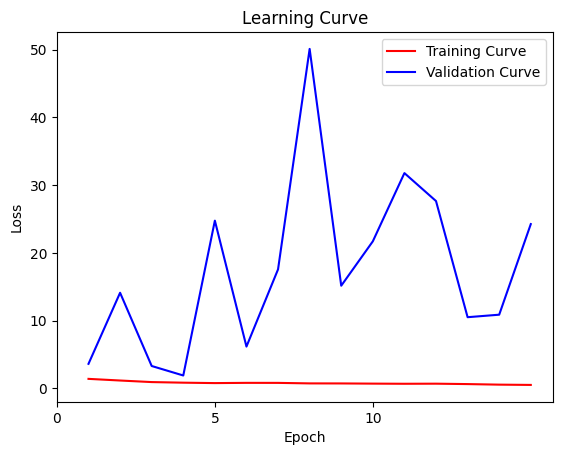

100%|██████████| 19/19 [00:00<00:00, 43.98it/s]

Confusion Matrix:
tensor([[1, 2, 0, 2],
        [1, 1, 2, 1],
        [2, 0, 0, 2],
        [0, 0, 0, 5]], device='cuda:0')
Precision: 0.2708
Recall: 0.3500
F1 Score: 0.2847
Accuracy: 0.3684


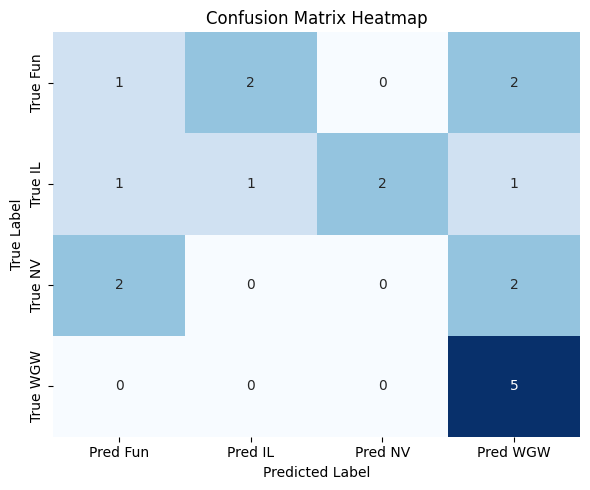

<Figure size 640x480 with 0 Axes>

In [80]:
num_epochs = 15

df, num_cols, one_hot_cols, all_tabular_cols = load_and_preprocess_csv(CSV_PATH)
df_train, df_val, df_test, scale_fn = split_and_scale(df, all_tabular_cols)
train_loader, val_loader, test_loader, train_ds = create_dataloaders(df_train, df_val, df_test, scale_fn)

tabular_dim = train_ds[0][2].shape[0]
num_classes = df[LABEL_COL].nunique()
print(f"Number of features:{tabular_dim}")

model, criterion, optimizer, scheduler= initialize_model(tabular_dim, num_classes)
best_model_path, train_loss_list, val_loss_list = train(num_epochs, model, criterion, optimizer, scheduler, train_loader, val_loader)
plt_lc(num_epochs, train_loss_list, val_loss_list)
confusion_matrix_result = predict(best_model_path, model, test_loader, num_classes)

plot_confusion_matrix(confusion_matrix_result)